In [2]:
import spacy
import re
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from unidecode import unidecode
from nltk import bigrams

In [3]:
nlp = spacy.load("fr_core_news_sm")
stopwords = list(nlp.Defaults.stop_words)
punctuation = list(string.punctuation)
s_stemmer = SnowballStemmer("french")

In [14]:
df = pd.read_csv('database.csv',parse_dates=['publishedAt','extractedAt'])
df.head()

,channelId,videoId,author,publishedAt,comment,extractedAt
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10


In [50]:
text = input("l'expression :")
cleaned_text = input("l'expression nettoyée :")
expressions = {
        're upload':'reupload',
        'déjà vu': 'deja_vu',
        'hab':'habitude',
        'pop culture': 'pop_culture',
        'lol' :'mort_de_rire', 
        'mdr':'mort_de_rire',
        'kendrick lamar' : 'kendrick_lamar',
        'annee 20' : 'annee_20',
        'trop bien' : 'trop_bien',
        'tyler the creator' : 'tyler_the_creator',
        'tyler creator' : 'tyler_the_creator',
        'childish gambino' : 'childish_gambino',
        'donald glover' : 'donald_glover',
        'chef d oeuvre' : 'chef_d_oeuvre',
        'aime bien' : 'aime_bien'#,
        #'vidéo sur' : 'video_sur'
        }
expressions.update({text: cleaned_text})
for e in expressions:
        print(e, expressions[e])

re upload reupload
déjà vu deja_vu
hab habitude
pop culture pop_culture
lol mort_de_rire
mdr mort_de_rire
kendrick lamar kendrick_lamar
annee 20 annee_20
trop bien trop_bien
tyler the creator tyler_the_creator
tyler creator tyler_the_creator
childish gambino childish_gambino
donald glover donald_glover
chef d oeuvre chef_d_oeuvre
aime bien aime_bien
video sur video_sur


In [12]:
# ÉCRIRE UN FICHIER AVEC LES EXTRAS STOPWORDS ET LES EXPRESSIONS que l'utilisateur pourra agrémenter : 
# appel de la fonction s'il y a un input, ouverture et écriture des lignes supplémentaires, sauvegarde du document pour utilisation
def expressions_frequentes(text):
    # expressions = {
    #     're upload':'reupload',
    #     'déjà vu': 'deja_vu',
    #     'hab':'habitude',
    #     'pop culture': 'pop_culture',
    #     'lol' :'mort_de_rire', 
    #     'mdr':'mort_de_rire',
    #     'kendrick lamar' : 'kendrick_lamar',
    #     'annee 20' : 'annee_20',
    #     'trop bien' : 'trop_bien',
    #     'tyler the creator' : 'tyler_the_creator',
    #     'tyler creator' : 'tyler_the_creator',
    #     'childish gambino' : 'childish_gambino',
    #     'donald glover' : 'donald_glover',
    #     'chef d oeuvre' : 'chef_d_oeuvre',
    #     'aime bien' : 'aime_bien'#,
    #     #'vidéo sur' : 'video_sur'
    #     }
    
    with open('../ressources/extra_expressions.txt', 'r') as file:
        expressions = file.read()
    
    for key, value in expressions.items():
        text = re.sub(key, value, text.lower())
    return text

def reduire_repetitions(mot):
    # nettoyage des répétitions de lettres
    # On remplace les répétitions de lettres par une seule occurrence
    # Ex: "loooove" devient "love"
    return re.sub(r'(.)\1{2,}', r'\1', mot)

def preprocessing(text, join=True, methode='lemma', extra_stopwords : list = None, extra_punctuation : list = None, extra_pattern : re.Pattern=None):
    extra_stopwords = extra_stopwords or []
    extra_punctuation = extra_punctuation or []
    nondesiredtokens = set(punctuation + stopwords + extra_punctuation + extra_stopwords)
    
    text = expressions_frequentes(text) 

    # pattern = re.compile(r"(http://\S+|@\S+|.*\d.*|.*\#.*)") 
    pattern = re.compile(r'http.+')

    # Tokenisation et nettoyage en une seule passe
    if methode == 'lemma':
        tokens = [unidecode(pattern.sub("", token.lemma_.lower()))  for token in nlp(text) if not token.is_stop and not token.is_digit and token.text.lower() not in nondesiredtokens and len(token) > 3]
    elif methode == 'stem':
        tokens = [unidecode(pattern.sub("", s_stemmer.stem(token.text.lower())))  for token in nlp(text) if not token.is_stop and not token.is_digit and token.text.lower() not in nondesiredtokens and len(token) > 3]
    
    # Filtrer les tokens vides après suppression des liens/mentions
    cleaned_tokens = [reduire_repetitions(token) for token in tokens if len(token)>3]
    # re.sub(r'\-{1,}|\\{1,}|\/{1,}|\_{1,}|~{1,}|\*{1,}|\?{1,}|\={1,}|\:{1,}|\){1,}|\({1,}', '',
    
    return " ".join(cleaned_tokens) if join else cleaned_tokens

In [8]:
def transformer(data :pd.DataFrame, text:str, text_cleaned:str, join=True):
    df = data.dropna(subset=[text])
    df[text_cleaned] = df[text].apply(lambda x: preprocessing(x, methode='lemma', join=join))
    return df

In [61]:
# # pattern = re.compile(r"(http://\S+|@\S+|.*\d.*|.*\#.*)") 
# df['tokens_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=False, extra_stopwords=['vidéo','vidéos','video','videos','.', 'jsuis', 'heyy', 'faire'], extra_punctuation=[']']))
# df['comment_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=True, extra_stopwords=['vidéo','vidéos','video','videos','.', 'jsuis', 'heyy', 'faire'], extra_punctuation=[']']))


In [13]:
# df['tokens_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=False))
# df['comment_clean_lem'] = df['comment'].astype(str).apply(lambda x: preprocessing(x, join=True))

df = transformer(df, 'comment', 'comment_clean_lem')
df = transformer(df, 'comment', 'tokens_clean_lem')

AttributeError: 'str' object has no attribute 'items'

In [8]:
df.head(25)

,channelId,videoId,author,publishedAt,comment,extractedAt,tokens_clean_lem,comment_clean_lem
0,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@SEBFRIT,2025-06-02 19:21:45+00:00,Merci à Odoo le sponsor cette vidéo ! Pour déc...,2025-07-01 11:46:10,"[odoo, sponsor, video, decouvrir, odoo, clique...",odoo sponsor video decouvrir odoo clique decou...
1,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@guishoo4700,2025-06-30 18:45:12+00:00,Fait une vidéo sur Tyler the creator stp,2025-07-01 11:46:10,"[video_sur, tyler_the_creator]",video_sur tyler_the_creator
2,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Remi-B-Goode,2025-06-30 16:35:49+00:00,Lol le disclaimer😂,2025-07-01 11:46:10,"[mort_de_rire, disclaimer]",mort_de_rire disclaimer
3,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@Guaph,2025-06-29 20:17:58+00:00,"où peut-on voir la série ""Earn and Alfred"" ???",2025-07-01 11:46:10,"[voir, serie, earn, alfred]",voir serie earn alfred
4,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@rockman156,2025-06-29 19:05:12+00:00,C'est pas un re upload ? Impression de déjà vu...,2025-07-01 11:46:10,"[reupload, impression, deja_vu, critique, foir...",reupload impression deja_vu critique foireux i...
5,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@r_bin,2025-06-29 16:30:34+00:00,fais une vidéo sur tyler the creator stpppppppp,2025-07-01 11:46:10,"[video_sur, tyler_the_creator, stp]",video_sur tyler_the_creator stp
6,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@collet_1311,2025-06-29 05:15:45+00:00,C est pas SEB c est un robot 😅😅😅,2025-07-01 11:46:10,[robot],robot
7,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@vladimiro.6067,2025-06-28 11:45:19+00:00,"Super vidéo comme d’hab, mais je trouve comme ...",2025-07-01 11:46:10,"[super, video, habitude, trouver, trop, indivi...",super video habitude trouver trop individualis...
8,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@CopainCodex,2025-06-28 02:33:23+00:00,la coiffure et le rasage ne me dérange pas le ...,2025-07-01 11:46:10,"[coiffure, rasage, deranger, monde, contre, gr...",coiffure rasage deranger monde contre gresille...
9,UCK3inMNRNAVUleEbpDU1k2g,24Ob5JxhF4s,@clem2023,2025-06-27 17:28:13+00:00,Super vidéo Seb merci vraiment mais par contre...,2025-07-01 11:46:10,"[super, video, vraiment, contre, faillir, tape...",super video vraiment contre faillir taper tete...


<Axes: title={'center': 'Most Common Words in Comments'}, xlabel='Samples', ylabel='Counts'>

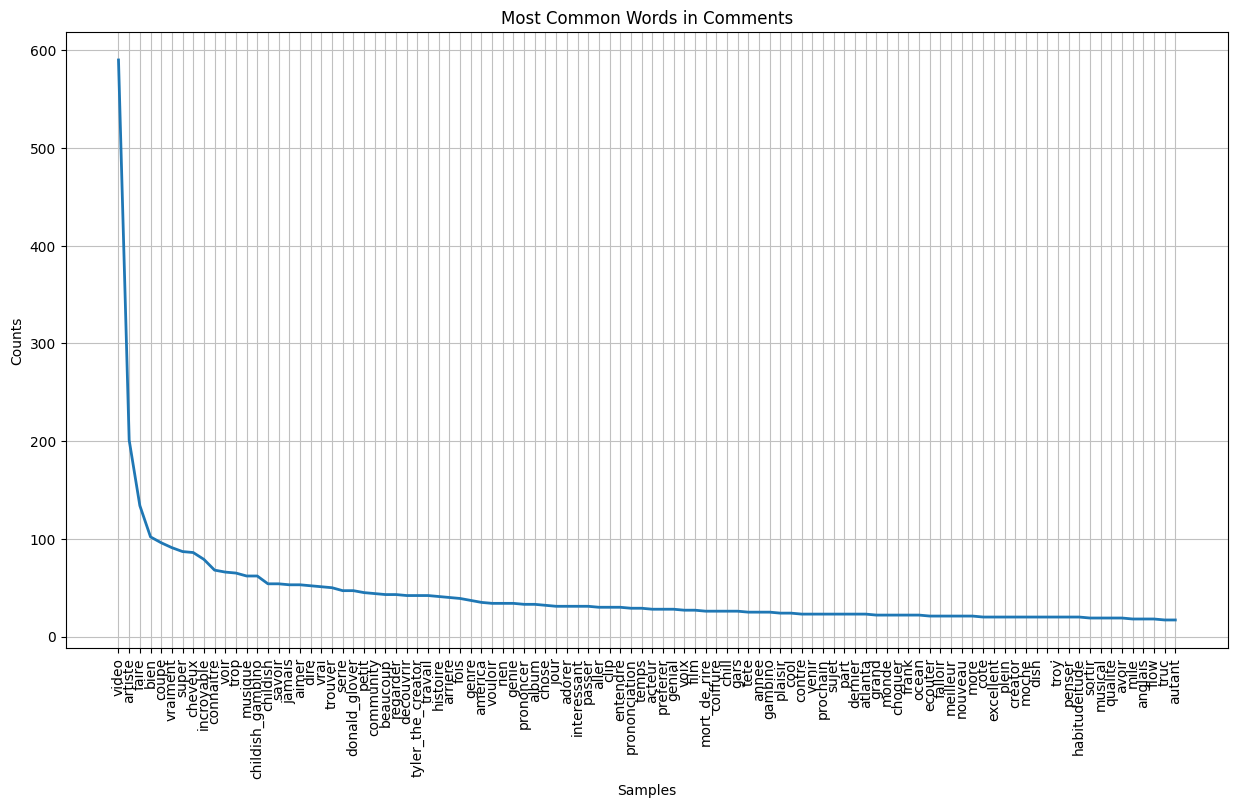

In [25]:
text = nltk.word_tokenize(' '.join(df['comment_clean_lem'].dropna()))
raw = nltk.Text(text)
fdistr = FreqDist(raw)
# freqDist ne fonctionne que sur des fichiers traités or c'est ce qu'on a fait avec le découpage en mot
# donc ça compte bien la fréquence des mots
# si on prend le fichier brut sans le couper en mots ça compte la fréquence de caractères
plt.figure(figsize=(15, 8))
fdistr.plot(100, cumulative=False, title='Most Common Words in Comments')

In [33]:
print(f"nombre de tokens : {len(nltk.word_tokenize(' '.join(df['comment'].dropna())))}")
print(f"nombre de tokens : {len(nltk.word_tokenize(' '.join(df['comment_clean_lem'].dropna())))}")
print(f"le nombre de commentaires : {df.shape[0]}")
print(fdistr.most_common())
print(FreqDist(list(bigrams(nltk.word_tokenize(' '.join(df['comment_clean_lem'].dropna()))))).most_common())


nombre de tokens : 34647
nombre de tokens : 11723
le nombre de commentaires : 1731
[('video', 590), ('artiste', 201), ('faire', 134), ('bien', 102), ('coupe', 96), ('vraiment', 91), ('super', 87), ('cheveux', 86), ('incroyable', 79), ('connaitre', 68), ('voir', 66), ('trop', 65), ('musique', 62), ('childish_gambino', 62), ('childish', 54), ('savoir', 54), ('jamais', 53), ('aimer', 53), ('dire', 52), ('vrai', 51), ('trouver', 50), ('serie', 47), ('donald_glover', 47), ('petit', 45), ('community', 44), ('beaucoup', 43), ('regarder', 43), ('decouvrir', 42), ('tyler_the_creator', 42), ('travail', 42), ('histoire', 41), ('arriere', 40), ('fois', 39), ('genre', 37), ('america', 35), ('vouloir', 34), ('rien', 34), ('genie', 34), ('prononcer', 33), ('album', 33), ('chose', 32), ('jour', 31), ('adorer', 31), ('interessant', 31), ('passer', 31), ('aller', 30), ('clip', 30), ('entendre', 30), ('prononciation', 29), ('temps', 29), ('acteur', 28), ('preferer', 28), ('genial', 28), ('voix', 27), ('f

In [27]:
590/df.shape[0] * 100

34.084344309647605

In [ ]:
def most_common_words(df, n=33):
    nb_comments = df.shape[0]
    freq = fdistr.most_common()
    extra_stopwords = []
    for word, count in freq:
        if count/ nb_comments >= n:
            extra_stopwords.append(word)
    return extra_stopwords

In [ ]:
def most_common_collocation(df, n=33):
    # On peut utiliser nltk.collocations pour trouver les collocations
    text = nltk.Text(nltk.word_tokenize(' '.join(df['comment_clean_lem'].dropna())))
    finder = nltk.collocations.BigramCollocationFinder.from_words(text)
    bigrams = finder.nbest(nltk.collocations.BigramAssocMeasures().pmi, 100)
    
    extra_collocations = []
    for bigram in bigrams:
        if len(bigram) == 2 and text.count(bigram) / df.shape[0] >= n:
            extra_collocations.append(" ".join(bigram))
    return extra_collocations

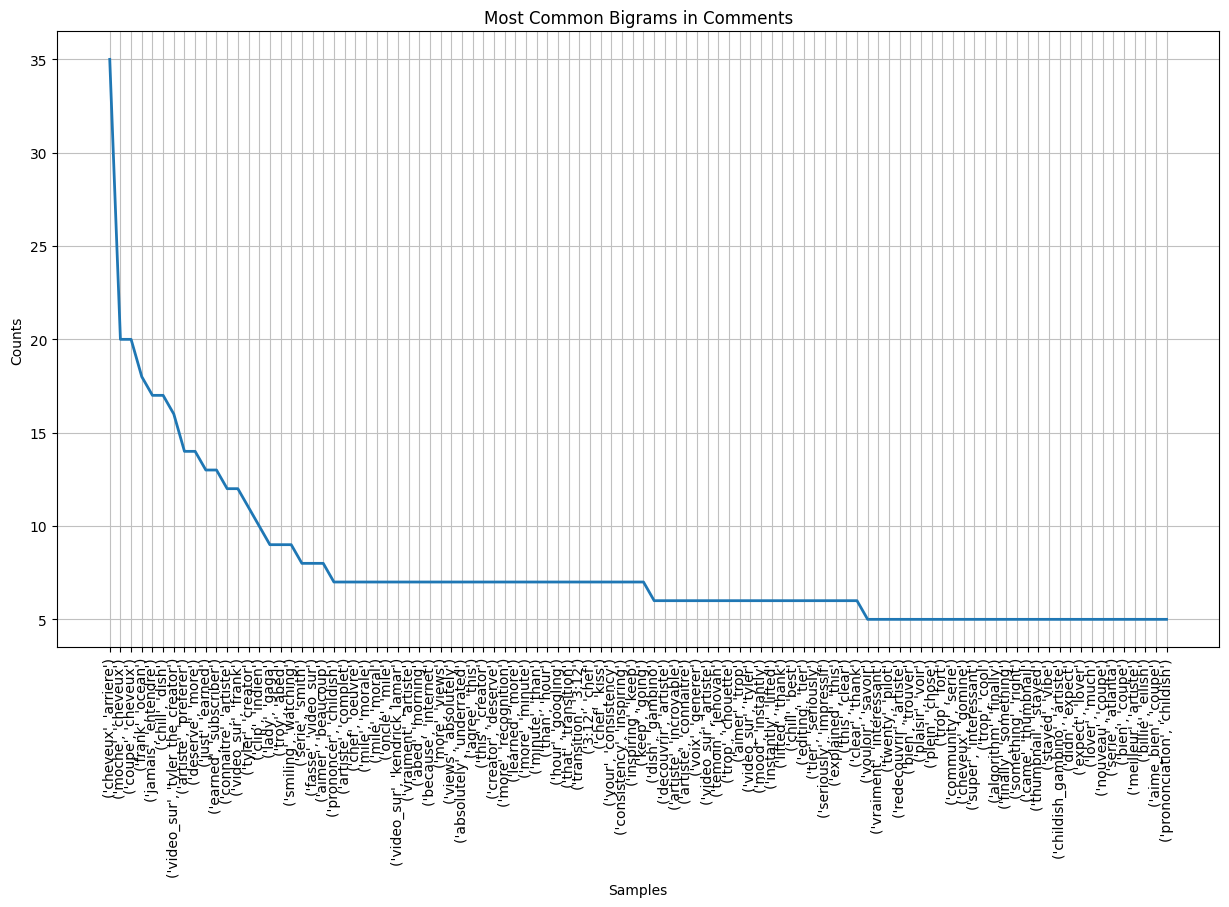

In [64]:
# afficher les bigrams les plus fréquents
from nltk import bigrams
bigrams_list = list(bigrams(text))
bigrams_freq = FreqDist(bigrams_list)
plt.figure(figsize=(15, 8))
bigrams_freq.plot(100, cumulative=False, title='Most Common Bigrams in Comments')
plt.show()



In [30]:
# bigrams_list = list(bigrams(text))
# bigrams_freq = FreqDist(bigrams_list)
# bigrams_freq

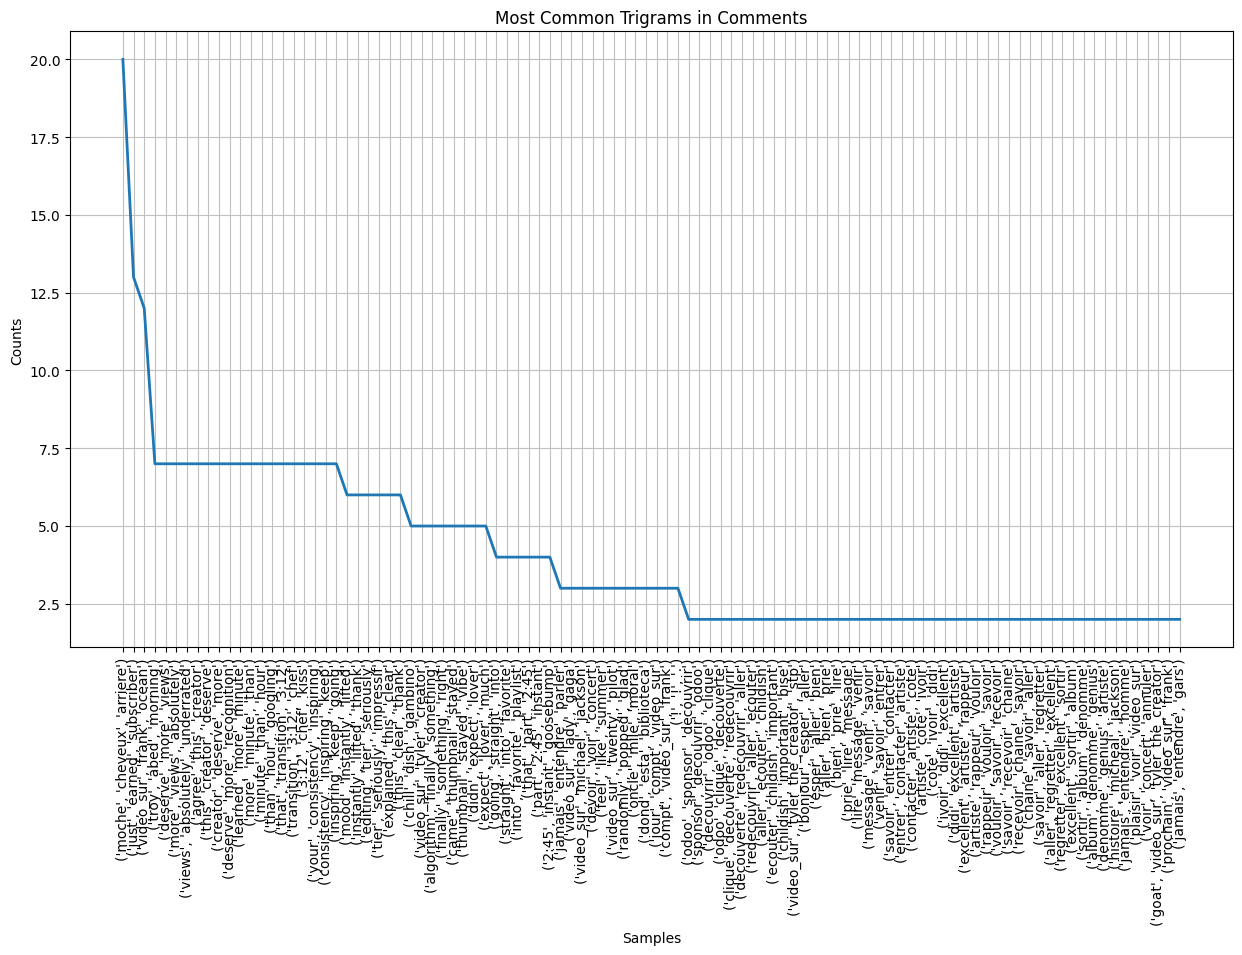

In [65]:
# afficher les trigrams les plus fréquents
from nltk import trigrams
trigrams_list = list(trigrams(text))
trigrams_freq = FreqDist(trigrams_list)
plt.figure(figsize=(15, 8))
trigrams_freq.plot(100, cumulative=False, title='Most Common Trigrams in Comments')
plt.show()

In [66]:
# afficher le contexte de 'artiste'
from nltk import Text
text_nltk = Text(text)
text_nltk.concordance('video', lines=25, width=100)

Displaying 3 of 3 matches:
art genre video_sur personne polyvalent penser video magnifique reve chacune artiste childish_gambi
iderman mile moral vraiment artiste admire yes video childish_gambino idole trop hater regarder bos
e pouce chial video_sur artiste preferer super video ! espece bruit bourdonnement agreable nouveau 


In [67]:
from nltk import Text
text_nltk = Text(text)
text_nltk.concordance('bien',lines=100 ,width=30)

Displaying 100 of 102 matches:
 esper aller bien prie lire me
 esper aller bien prie lire me
eirdo ouirdo bien childish cha
cer childish bien jouer bait t
tudeill gemo bien content bien
bien content bien bien ecrire 
content bien bien ecrire inter
oupe cheveux bien trouver plac
rtout poulet bien tenter intro
nder vouloir bien video_sur hi
uter musique bien aime spiderm
e coupe trer bien sort tyler_t
nd regrouper bien idee defends
ibliotheca . bien utiliser voi
tre conduire bien else here be
nt connaitre bien aimer smith 
coup aimerai bien devrai video
show realite bien lipovetsky c
heure merite bien meilleur exp
e vend coupe bien cryptobro bo
ek connaitre bien transparaitr
 coiffure va bien clean chill 
r incroyable bien aimer habitu
base trouver bien foutu pout i
oup parcours bien sceptique ut
over trouver bien resume since
lip utiliser bien support expr
oup coiffure bien pitier forma
eplace doute bien choix reflec
ix reflechit bien idee suppose
lire extrait bien fonctionner 
eux ah i

# Écriture du fichier

In [68]:
df.to_csv('database_clean.csv', index=False)